# Fashion MNIST with Vanilla JAX

- toc: true
- badges: true
- comments: false
- categories: [deep learning, JAX]

## Introduction

In this post, I'm going to implement a basic Fashion-MNIST classifier using JAX.  JAX is an array-processing library that uses Google's XLA (Accelerated Linear Algebra) compiler to generate high-performance code that can run on a variety of hardware platforms.  It feels a lot like numpy, with a number of advantages including built in automatic differentiation, vectorization and parallelization, and just-in-time compilation.  


By the end of this write up, I'm going to end up with this:

```python
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 
train_dataset = Dataset(X_train, y_train)
valid_dataset = Dataset(X_test, y_test)
train_datasource = Dataloader(train_dataset, batchsize=32)
valid_datasource = Dataloader(valid_dataset, batchsize=32)

network = Sequential(
    rescale_image,
    flatten,
    Linear(28*28, 128),
    relu,
    Linear(128, 10),
    softmax  
)

grad_fn = jax.jit(jax.grad(lambda model, X, y: sparse_cross_entropy(y, model(X))))

history = train(
    num_epochs=5, 
    train_datasource=train_datasource, 
    valid_datasource=valid_datasource,
    optimizer=Adam(network, lr=1e-3), 
    loss_fn=sparse_cross_entropy, 
    model=network,
    grad_fn=grad_fn
)
```

```
Epoch 1/5
1874/1875  [===============================] - 2s  1.65ms/batch - loss: 0.4956  - accuracy: 0.8250     - val_loss: 0.4446 - val_accuracy: 0.8396
Epoch 2/5
1874/1875  [===============================] - 2s  1.40ms/batch - loss: 0.3716  - accuracy: 0.8654     - val_loss: 0.4271 - val_accuracy: 0.8446
Epoch 3/5
1874/1875  [===============================] - 2s  1.39ms/batch - loss: 0.3330  - accuracy: 0.8791     - val_loss: 0.4034 - val_accuracy: 0.8528
Epoch 4/5
1874/1875  [===============================] - 2s  1.46ms/batch - loss: 0.3079  - accuracy: 0.8871     - val_loss: 0.3797 - val_accuracy: 0.8616
Epoch 5/5
1874/1875  [===============================] - 2s  1.97ms/batch - loss: 0.2891  - accuracy: 0.8935     - val_loss: 0.3599 - val_accuracy: 0.8710
```

Besides using the Keras datasets library, everything will be written from scratch.  My goal is to demonstrate how simple it is to build the begininnings of a deep-learning library when you're working with the right set of tools. 

## Load Libraries

In [107]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time 

from typing import Tuple, List, Any, Dict, Callable

eps = jnp.finfo(jnp.float64).eps

## Loading the Data

The `Dataset` and `Dataloader` classes shown below are stripped down versions of the Pytorch versions.  For now, a `Dataset` is a container for JAX feature and label arrays.  In fact, besides having a length ( because it has a `__len__` method), it's pretty useless.  The `Dataloader` gives you the ability to iterate over batches of data from a `Dataset`, which is very important for effective model training.

In [108]:
class Dataset:
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return jnp.shape(self.X)[0]
    def __getitem__(self, i):
        return self.X[i,:], self.y[i]

In [109]:
class Dataloader:
    def __init__(self, dataset: Dataset, batchsize=32, shuffle=False):
        self.dataset = dataset
        self.batchsize = batchsize
        self.shuffle = shuffle
    def __iter__(self):
        for i in range(0, len(self.dataset), self.batchsize): 
            yield self.dataset[i:i+self.batchsize]
    def __len__(self):
        return len(self.dataset) // self.batchsize
        

Let's go through an example of using `Dataset` and `Dataloader`.  First grab the Fashion MNIST data using the Keras dataset library.  

In [201]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 
print(f'Number training examples = {len(y_train)}')
print(f'Number testing examples = {len(y_test)}')

Number training examples = 60000
Number testing examples = 10000


There are ten articles of clothing represented in the dataset.  Here's the array that map an index to its name.

In [183]:
class_labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

Now let's put the training data into a dataloader configured to generate batches with 8 images, and show the first set of images with their labels. First I need to import the `Image` module from the `PIL` library.  Looping over `dataloader` will give you all 8-image batches in the training set.  Putting a `break` statement at the end of the loop, we're limited to looking at the first batch.

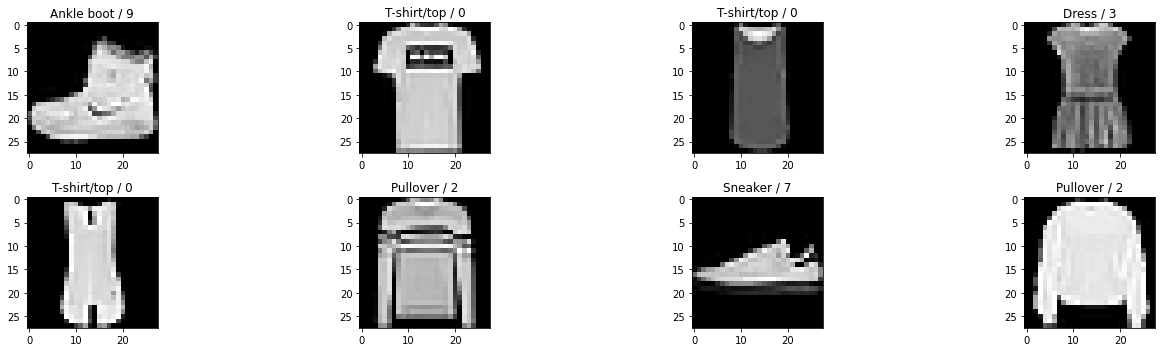

In [215]:
from PIL import Image
dataloader = Dataloader(Dataset(X_train, y_train), batchsize=8)


for X_batch, y_batch in dataloader:
    plt.figure(1, figsize=(20,5))
    for i, (X, y) in enumerate(zip(X_batch, y_batch)):
        img = Image.fromarray(X)
        plt.subplot(2,4,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{class_labels[y]} / {y}')
    plt.tight_layout()
    
    break


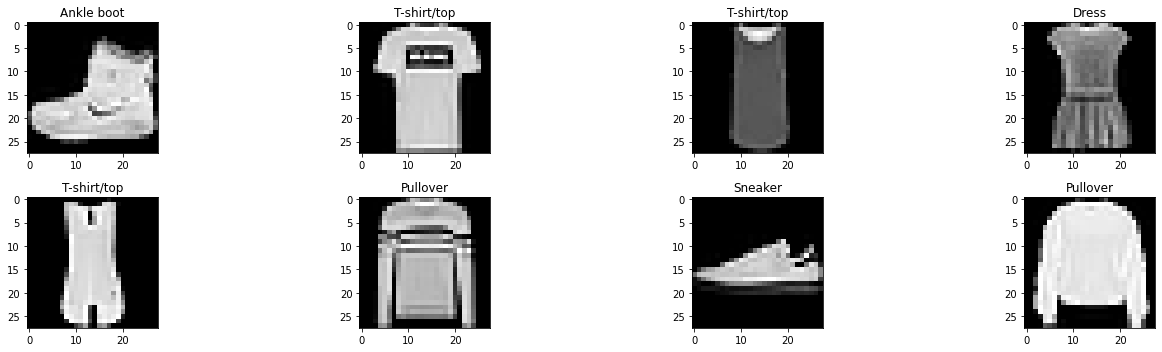

In [204]:


plt.figure(1, figsize=(20,5))
for i, (X, y) in enumerate(zip(X_0, y_0)):
    img = Image.fromarray(X)
    plt.subplot(2,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(class_labels[y])
plt.tight_layout()

## The Sequential Model

A sequential model is a list of `Callable` objects that is evaluated by calling each members `__call__` method in order.  Each list element is a registered pytree, but I also wanted to have the flexibility to pass ordinary functions to the `Sequential` constructor and have everything just work.  As you'll soon see this feature was implemented by modifying the `__init__` method.

### `Linear` Layer


The `Linear` layer defined below is very similar to implementations (but less general) you'd find in other non-JAX neural network libraries.  

In [111]:
@jax.tree_util.register_pytree_node_class
class Linear:
    w: jnp.ndarray 
    b: jnp.ndarray
    ni: int 
    no: int 

    def __init__(self, num_inputs, num_outputs, build=True, seed=1234):
        self.ni = num_inputs 
        self.no = num_outputs 
        # want to add seed as internal object
        if build:
            key = jax.random.PRNGKey(seed)
            self.w = jax.random.normal(key, (num_inputs, num_outputs)) * jnp.sqrt(2.0 / num_inputs)
            self.b = jnp.zeros(num_outputs)

    def __repr__(self):
        return f'Linear(num_inputs={self.ni}, num_outputs={self.no})'
        
    def __call__(self, x):
        return jnp.dot(x, self.w) + self.b
        
    def params(self):
        return {'w': self.w, 'b': self.b}
    
    def tree_flatten(self):
        return (self.w, self.b), (self.ni, self.no)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        layer = cls(*aux_data, build=False)
        layer.w, layer.b = children
        return layer

The one glaring difference is the decorator and the two *tree* methods.  As the JAX documentation explains, the `register_pytree_node_class`, `tree_flatten` method, and `tree_unflatten` class methods are required to add a user-defined class to the JAX pytree registry.  Once added, JAX will know how to transform back and forth between objects that the rest of JAX system can efficiently operate on, and objects that are specific to your application.    

The `tree_flatten` method returns a two-element tuple consisting of the parameters you want to expose to JAX, and any meta-data that can help reconstruct the object.  Because JAX embraces the functional paradigm of immutable data structures, I thought it might be better to express the parameters as a tuple.  For `Linear`, the parameters are the weights and biases of the neural network.  For now, the only meta-data that seems helpful are the number of inputs and outputs (although this could be derived from the shape of the weights.  

Another noteworthy thing about `Linear` is the `build` attribute.  Most of the time, you want to initialize the weights and biases at creation time time.  However, you don't want to do this when JAX reconstructs the object from it's flattened representation.  You probably just want to plop the parameters right into a freshly constructed object. The `build` attribute gives you some flexibility in that regard.  

Let's take a look at a small example to see what we have.  Here's a linear layer that maps 5-element arrays to 1-element arrays

In [221]:
lin = Linear(5, 1)

Because `Linear` is a pytree, it can be passed to `jax.tree_flatten` to get it's weights and biases, and it's metadata:

In [232]:
params, metadata = jax.tree_flatten(lin)
print(f'weights = {params[0]}, biases = {params[1]}')
print(f'metadata = {metadata}')

weights = [[ 0.5734188 ]
 [-0.597884  ]
 [ 0.05189713]
 [-1.1660179 ]
 [ 0.29061902]], biases = [0.]
metadata = PyTreeDef(CustomNode(<class '__main__.Linear'>[(5, 1)], [*, *]))


Finally, the metadata and parameters from `jax.tree_flatten` can be used to generate a clone of the `lin`:

In [233]:
lin2 = jax.tree_unflatten(metadata, params)

Just to make sure that the weights, biases, and model outputs match:

In [238]:
assert jnp.all(jnp.isclose(lin.w, lin2.w))
assert jnp.all(jnp.isclose(lin.b, lin2.b))

x = np.random.randn(10,5)
assert jnp.all(jnp.isclose(lin(x), lin2(x)))

### `Function` Layer

The `Function` class fills the same need that `Lambda` layers do in Keras: being able to conveniently plug functions into models.  As the `tree_flatten` method shows, classes registered as pytrees can be parameter-free. 

In [112]:
@jax.tree_util.register_pytree_node_class
class Function:
    def __init__(self, fn):
        self.fn = fn 
        
    def __call__(self, x):
        return self.fn(x)
    
    def __repr__(self):
        return f'Function({self.fn.__name__})'
    
    def tree_flatten(self):
        return [], self.fn

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(aux_data)
    

### Helpful Functions

Here are a few functions that will be *lifted* to `Function` layer in the `Sequential` model.  One common approach for improving classification accuracy is to normalize your input data.  When working with gray-scale images, this typically means rescaling the pixels from $[0,255]$ to $[0,1]$.  This is what `rescale_image` does.

In [113]:
def rescale_image(x): return x / 255.0

The model built in this post operates on batches of two-dimensional gray-scale images.  Each batch is a three-dimensional array and can be interpreted as a vertical stack of 2D images, where the height of the vertical stack is the number of images.  The `flatten` goes through each slice of the vertical stack and transforms the 2D array into a one-dimensional array.  In the process, the 3D input becomes a 2D array.

In [114]:
def flatten(x):
    shape = jnp.shape(x)
    assert len(shape) == 3, 'x must represent a batch of two-dimensional gray-scale images' 
    batch_size = shape[0]
    return jnp.reshape(x, (batch_size, -1)) 
    

The last two functions we'll implement in this section are `relu` and `softmax`.  A couple of tests are also provided. 

In [115]:
def relu(x): return jnp.clip(x, a_min=0)    

x = np.random.randn(10,10)
assert np.all(np.isclose(relu(x), tf.nn.relu(x))), 'test failed'

In [116]:
def softmax(x):
    ex = jnp.exp(x)
    return ex / jnp.sum(ex, axis=-1, keepdims=True)    

x = np.random.randn(5, 10)
assert np.all(np.isclose(softmax(x), tf.nn.softmax(x))), 'test failed'
assert np.isclose(jnp.sum(softmax(x)), jnp.shape(x)[0])

### Sequential Model

With the supporting pieces implemented, the `Sequential` class can be defined.

In [117]:
@jax.tree_util.register_pytree_node_class
class Sequential:

    def __init__(self, *layers):
        self.layers = []
        for layer in layers:
            if hasattr(layer, 'tree_flatten'):
                self.layers.append(layer)
            elif callable(layer):
                self.layers.append(Function(layer))
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __repr__(self):
        string = ''
        for layer in self.layers:
            string += (repr(layer) + '\n')
        return string
    
    def tree_flatten(self):
        aux_data, children = [], []
        for layer in self.layers:
            params, extra_stuff = jax.tree_flatten(layer)
            aux_data.append(extra_stuff)
            children.append(params)
        return children, aux_data
    
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        layers = []
        for params, spec in zip(children, aux_data):
            layers.append(jax.tree_unflatten(spec, params))
        return Sequential(*layers)

Based on the previous high-level description, it should not be surprising that `Sequential` is essentially a wrapper around a list of layers.  The `__init__` method loops through the list of input objects and does one of the following things:

1. if it is a pytree, adds the layer to the list of layers
2. if it is a function, but not a pytree, wraps the function in a `Function` object and adds the pytree to the list of layers.

Either way, at the end of construction, each `Sequential` instance is a list of pytrees.  At this point, `Sequential` is made into a pytree in the usual way: by implementing `tree_flatten` and `tree_unflatten` which loop over the layers, calling each layer's flatten of unflatten method, and collecting the results.

## Cross Entropy Loss

Cross Entropy is one of the most common loss functions for classification problems.  I'm going to spare you the long-winded mathematical justification of why it's a useful function.  Let me just say that it measures how close two probability distributions are. 

Here are two different versions of cross-entropy.  The first version (`cross_entropy`) assumes that `y_true` is one-hot encoded while the second version (`sparse_cross_entropy`) assumes that `y_true` is an array of indices.  I like the sparse version because it seems more efficient and less dependent on knowing the number of categories in the dataset.  

In [120]:
@jax.jit
def cross_entropy(y_true, probs):
    batch_size = jnp.shape(probs)[0]
    return -jnp.sum(jnp.log(probs + eps) * y_true) / batch_size

y_true = np.array([[0, 1, 0], [0, 0, 1]])
y_pred = np.array([[0.05, 0.95, 0.0], [0.1, 0.8, 0.1]])
keras_cross_entropy = tf.keras.losses.CategoricalCrossentropy()
assert np.all(np.isclose(cross_entropy(y_true, y_pred), keras_cross_entropy(y_true, y_pred))), 'Not close'

In [121]:
@jax.jit
def sparse_cross_entropy(y_true, probs):
    batch_size = len(y_true)
    X = jnp.log(probs + eps)[jnp.arange(batch_size), y_true]
    return -jnp.sum(X) / batch_size

y_true = jnp.array([1, 2])
y_pred = jnp.array([[0.05, 0.95, 0.0], [0.1, 0.8, 0.1]])
keras_cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
assert np.all(np.isclose(sparse_cross_entropy(y_true, y_pred), keras_cross_entropy(y_true, y_pred))), 'Not close'

## Optimizers

Optimizers update model parameters at each minibatch.  The simplest optimizer, stochastic gradient descent (aka SGD), is shown below and updates the parameters ($W$) as follows: 

$$
    W \leftarrow W - \alpha \frac{\partial \ell}{\partial W}
$$

where $\ell$ represents the loss-function used in model training and $\alpha$ is the learning rate.  

While certainly simple and fast, SGD is not the *go-to* optmizer these days.  That title seems to go to *Adam*, as it tends to be used in most examples I've seen.  From their original paper, Kingma and Ba describe Adam as 

> "an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments."

For now, an optimizer has an `__init__` and `step` method.  The `__init__` method initializes the parameters and `step` updates the model parameters.

In [122]:
class Optimizer: pass

In [123]:
class SGD(Optimizer):
    def __init__(self, model, lr=1e-3):
        self.lr = lr 
    def step(self, model, grads):
        return jax.tree_map(lambda p, g: p - self.lr*g, model, grads)

In [124]:
class Adam(Optimizer):
    def __init__(self, model, lr=1e-3, v_decay=0.9, s_decay=0.999, eps=1e-7):
        self.lr, self.v_decay, self.s_decay, self.eps = lr, v_decay, s_decay, eps
        self.v = jax.tree_map(lambda x: jnp.zeros_like(x), model) 
        self.s = jax.tree_map(lambda x: jnp.zeros_like(x), model)
        self.k = 0 
    def step(self, model, grad):
        lr, v_decay, s_decay, eps = self.lr, self.v_decay, self.s_decay, self.eps
        v, s = self.v, self.s
        k = self.k = self.k+1
        self.v = jax.tree_map(lambda v, g: v_decay*v +(1-v_decay)*g, v, grad)
        self.s = jax.tree_map(lambda s, g: s_decay*s +(1-s_decay)*g*g, s, grad)
        v_hat = jax.tree_map(lambda v: v / (1-v_decay**k), self.v)
        s_hat = jax.tree_map(lambda s: s / (1-s_decay**k), self.s)
        new_model = jax.tree_map(lambda params, v_hat, s_hat: params - (lr*v_hat)/(jnp.sqrt(s_hat) + eps), model, v_hat, s_hat)
        return new_model


This code illustrate why pytree registration is so important.  Consider the following line taken from `Adam`'s `step` method:

```python
self.v = jax.tree_map(lambda v, g: v_decay*v + (1-v_decay)*g, v, grad)
```

The passed in `lambda` is a function of two JAX arrays; `v` and `grads` are pytrees.  Internally, `jax.tree_map` executes 3 steps:

1. pytrees are flattened
2. function called on each item in the flattened pytree
3. results unflattened

## Progress Bar

I really like how Keras logs information to the screen during model training, and decided to mimic the style.  Here's my version of the progress bar.  

In [126]:
def progress_bar(percentage, total=30):
    x = int(percentage*total)
    if x < total:
        r = '[' + ''.join(['=']*x) + '>' + ''.join(['.']*(total-x)) + ']' 
    else:
        r = '[' + ''.join(['=']*(total+1)) + ']' 
    return r

It has space for 31 characters sandwiched between an opening and closing bracket.  Examples at various completion percentages are shown below.

* 0% progress

In [127]:
print(progress_bar(0))

[>..............................]


* 10% progress

In [128]:
print(progress_bar(0.1))

[===>...........................]


* 100% progress

In [159]:
print(progress_bar(1))

[===============================]


## The Training Loop  

The training loop is pretty simple, but I admit that it looks a little cluttered.  Most frameworks and libraries split the it into several separate functions, and incorporate a callback system that allows a user to customize it's functionality.  Without the flexibility that a callback system offers, you'd probably need to implement a new training loop for every project.  Besides that, callbacks lend themselved to less cluttered (and therefore less buggy) code.  I'll likely work on some semi-simple callback system in the future.



In [144]:
def train(num_epochs, train_datasource, valid_datasource, optimizer, loss_fn, grad_fn, model):
    history = {'loss':[], 'accuracy':[]}
    
    if valid_datasource is not None:
        history = {**history, 'valid_loss': [], 'valid_accuracy': []}

    train_num_batches = len(train_datasource)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # TRAINING PHASE
        train_loss_accum, train_accuracy_accum, train_batch_size = 0, 0, 0
        
        num_steps = 0 
        
        epoch_duration = 0.0
        
        # we know how many batches there are ... keep track
        for i, (X_train, y_train) in enumerate(train_datasource):
            
            # logging
            batch_start = time.time()

            num_steps += 1
            
            # training loss and gradients for this particular batch
            probs = model(X_train)
            loss = loss_fn(y_train, probs)
            grad = grad_fn(model, X_train, y_train)
            model = optimizer.step(model, grad)
            
            
            # Results aggregation
            num_correct = jnp.sum(jnp.argmax(probs, axis=-1) == y_train)
            train_loss_accum += loss 
            train_batch_size += len(y_train)
            train_accuracy_accum += num_correct
            train_accuracy = train_accuracy_accum / train_batch_size
            train_loss = train_loss_accum / train_num_batches # average loss per batch

            # Logging ....
            batch_duration = time.time() - batch_start
            epoch_duration += batch_duration 
            log_batch_count = f'{i}/{train_num_batches}'
            log_epoch_time = f'{int(epoch_duration)}s'
            log_batch_time = f'{1_000*batch_duration:.2f}ms/batch'
            log_batch_loss = f'loss: {train_loss:.4f}'
            log_batch_accuracy = f'accuracy: {train_accuracy:.4f}'
            log_string =  f'{log_batch_count:<10s} {progress_bar((i+1)/train_num_batches)} - {log_epoch_time:<3s} {log_batch_time:<5s} - {log_batch_loss:<13s} - {log_batch_accuracy:<20s}'
            print(log_string, end='\r') 

        # 
        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)      

        # VALIDATION PHASE
        if valid_datasource is not None:
            valid_num_batches = len(valid_datasource)
            valid_loss_accum, valid_accuracy_accum, valid_batch_size = 0, 0, 0 

            # Run validation step ...
            for i, (X_valid, y_valid) in enumerate(valid_datasource):
                num_steps += 1
                probs = model(X_valid)
                loss = loss_fn(y_valid, probs)
                
                valid_accuracy_accum += jnp.sum(jnp.argmax(probs, axis=-1) == y_valid)

                valid_loss_accum += loss
                valid_batch_size += len(y_valid)

            epoch_valid_loss = valid_loss_accum / valid_num_batches
            epoch_valid_accuracy = valid_accuracy_accum / valid_batch_size
            log_valid_loss = f'val_loss: {epoch_valid_loss:.4f}'
            log_valid_accuracy = f'val_accuracy: {epoch_valid_accuracy:.4f}'
            log_string += f' - {log_valid_loss:<13s} - {log_valid_accuracy:<20s}' 
            
            history['loss'].append(epoch_valid_loss)
            history['accuracy'].append(epoch_valid_accuracy)
        
        # this log_string should include validation results
        print(log_string, end='\n')
    return history
    

## Execution

Okay, time to put everything together and train the model.  One thing that might require a little explanation is the line

```python
grad_fn = jax.jit(jax.grad(lambda model, X, y: sparse_cross_entropy(y, model(X))))
```

The inner `lambda` is the function that uses the model, image data, and labels to calculate the cross-entropy loss.  By default `jax.grad` will calculate the gradient with respect to this function's first argument, `model` (or equivalently it's flattened pytree representation).  This is precisely what we want.  To speed up the calculation the gradient is compiled with `jax.jit`.

In [145]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 
train_dataset = Dataset(X_train, y_train)
valid_dataset = Dataset(X_test, y_test)
train_datasource = Dataloader(train_dataset, batchsize=32)
valid_datasource = Dataloader(valid_dataset, batchsize=32)

network = Sequential(
    rescale_image,
    flatten,
    Linear(28*28, 128),
    relu,
    Linear(128, 10),
    softmax  
)

grad_fn = jax.jit(jax.grad(lambda model, X, y: sparse_cross_entropy(y, model(X))))

history = train(
    num_epochs=5, 
    train_datasource=train_datasource, 
    valid_datasource=valid_datasource,
    optimizer=Adam(network, lr=1e-3), 
    loss_fn=sparse_cross_entropy, 
    model=network,
    grad_fn=grad_fn
)



Epoch 1/5
1874/1875  [===============================] - 2s  1.65ms/batch - loss: 0.4956  - accuracy: 0.8250     - val_loss: 0.4446 - val_accuracy: 0.8396
Epoch 2/5
1874/1875  [===============================] - 2s  1.40ms/batch - loss: 0.3716  - accuracy: 0.8654     - val_loss: 0.4271 - val_accuracy: 0.8446
Epoch 3/5
1874/1875  [===============================] - 2s  1.39ms/batch - loss: 0.3330  - accuracy: 0.8791     - val_loss: 0.4034 - val_accuracy: 0.8528
Epoch 4/5
1874/1875  [===============================] - 2s  1.46ms/batch - loss: 0.3079  - accuracy: 0.8871     - val_loss: 0.3797 - val_accuracy: 0.8616
Epoch 5/5
1874/1875  [===============================] - 2s  1.97ms/batch - loss: 0.2891  - accuracy: 0.8935     - val_loss: 0.3599 - val_accuracy: 0.8710


## Keras Execution

For comparison, here's the training results for Keras on the same dataset.  

In [139]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255.0),
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)                          
])

model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 945us/step - loss: 0.5048 - accuracy: 0.8246 - val_loss: 0.4426 - val_accuracy: 0.8448
Epoch 2/5
1875/1875 [==============================] - 2s 927us/step - loss: 0.3779 - accuracy: 0.8637 - val_loss: 0.3890 - val_accuracy: 0.8589
Epoch 3/5
1875/1875 [==============================] - 2s 964us/step - loss: 0.3402 - accuracy: 0.8765 - val_loss: 0.3942 - val_accuracy: 0.8593
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3141 - accuracy: 0.8853 - val_loss: 0.3635 - val_accuracy: 0.8683
Epoch 5/5
1875/1875 [==============================] - 2s 997us/step - loss: 0.2954 - accuracy: 0.8911 - val_loss: 0.3466 - val_accuracy: 0.8777


I'm pretty pleased with how closely my output follows the Keras output. The reason there isn't an even better match possibly stems from different parameter initialization techniques.  I'm currently limited to Kaiming initialization, whereas Dense layers in Keras use Kaiming uniform by default.  I could test this hypothesis by directly loading the parameters in my model with the Keras parameters.  Maybe I'll try this in another day.

## Conclusion

JAX is a potent piece of technology.  I'm planning to use it, and explore how it works, in more detail over the coming months.  Overtime, I hope to take the parts and pieces implemented here and build a more cohesive library that can be used to solve problems that interest me.  